In [1]:
#basic script to investiagte chemical environment and to start constructing a decent input vector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances as pdist


In [197]:
#all the currently known and supported elements:

#GLOBAL VARIABLES

#trainign data
DATA = pd.read_csv('./clean_training.csv',index_col = 0)

#resolution of training
INTEGRATION_STEP = 1.

#SIZE OF INPUT VECTOR
MAX_ATOMS = 120

#ELEMENT DICTIONARY
names = [ 'I', 'Be', 'F', 'Li', 'Ce']
electrons = [53+1 , 4-2,9-1 ,3+1,58] #assume ionization state
protons   = [53, 4,9,3,58]
neutrons  = [127-53, 5,10,4,140-58]
element_dict= dict()
for i,name in enumerate(names):
    element_dict[name] = [electrons[i], protons[i], neutrons[i]]
    
    

In [211]:
#for a given atom I, it should be possible to extract the list of atoms closer than 5 
#then I could sort them by distance, the closest once will come first, there is a potential cutoff after 200 atoms?
#so the order of entries in the distance matrix is just the distance sorted, where distances > 5 result -1
#next layer encode number of electrons, neutrons, and protons per element 

def row2coords(row):
    '''convert dataframe rows into coordinates, also extract a list of atom names'''
    coords = np.zeros(((len(row)-2)//3,3))
    atom_names = []
    boundary = row[1]
    names = row.keys()

    for i in range((len(row)-2)//3):
        coords[i,:] = row[i*3+2:i*3+5]
        atom_names.append(get_first_string(names[i*3+2][:-1]))
    coords %= 2*boundary
    
    
    return coords, boundary, np.array(atom_names)

def get_input_vector(atom, timestep):
    '''PoC input vector: take a measured row and return the input vector for an atom i
       Initially construct the distance matrix for that atom and extract chemical information from element name'''
    row = DATA.loc[data['timestep'] == timestep].iloc[0]
    
    coords, boundary, atom_names = row2coords(row)
    distance_matrix = pdist(coords) % boundary
    
    distances = distance_matrix[atom,:]
    sort_idx = np.argsort(distances)
    sorted_dists = distances[sort_idx]
    sorted_atom_names = atom_names[sort_idx]
    distLess5 = np.where(sorted_dists < 5)
    #TODO vectorize these for loops!!!
    a_sorted = np.zeros((MAX_ATOMS,MAX_ATOMS,4))-1
    for i,idxi in enumerate(sort_idx[distLess5]):
        for j, idxj in enumerate(sort_idx[distLess5]):
            a_sorted[i,j,0] = distance_matrix[idxi,idxj]
        #add electrons
        a_sorted[i,:len(distLess5[0]),1] = [ element_dict[name][0] for name in sorted_atom_names[distLess5] ]
        #add protons
        a_sorted[i,:len(distLess5[0]),2] = [ element_dict[name][1] for name in sorted_atom_names[distLess5] ]
        #add neutrons
        a_sorted[i,:len(distLess5[0]),3] = [ element_dict[name][2] for name in sorted_atom_names[distLess5] ]
        
    return a_sorted

def plot_coords(c):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(c[:,0],c[:,1],c[:,2], cmap='Greens');
    plt.show()
    
def get_first_string(string):
    '''helper fct to extract leading string of string number'''
    import re
    match = re.match(r"([a-z]+)([0-9]+)", string, re.I)
    if match:
        return match.groups()[0]
    
def get_position_update(atom,timestep):
    data = pd.read_csv('./clean_training.csv',index_col = 0)
    row = DATA.loc[data['timestep'] == timestep].iloc[0]
    new_row = DATA.loc[data['timestep'] == timestep+INTEGRATION_STEP].iloc[0]
    update = new_row[2+atom*3:atom*3+5] - row[2+atom*3:atom*3+5]

    return np.array(update.values)

def get_current_velocity(atom,timestep):
    data = pd.read_csv('./clean_training.csv',index_col = 0)
    row = DATA.loc[data['timestep'] == timestep].iloc[0]
    new_row = DATA.loc[data['timestep'] == timestep-INTEGRATION_STEP].iloc[0]
    update = new_row[2+atom*3:atom*3+5] - row[2+atom*3:atom*3+5]

    return np.array(update.values)/INTEGRATION_STEP

def get_current_position(atom,timestep):
    data = pd.read_csv('./clean_training.csv',index_col = 0)
    row = DATA.loc[data['timestep'] == timestep].iloc[0]
    return np.array(row[2+atom*3:atom*3+5])

def get_next_position(atom,timestep):
    data = pd.read_csv('./clean_training.csv',index_col = 0)
    row = DATA.loc[data['timestep'] == timestep+INTEGRATION_STEP].iloc[0]
    return np.array(row[2+atom*3:atom*3+5])

In [212]:
#here I can now construct data for atoms at specific timesteps. Now we can start building CNNs!

velocity = get_current_velocity(10,38447.0)
position = get_current_position(10,38447.0)
next_position = get_next_position(10,38447.0)

iv = get_input_vector(10,38447.0)
label = get_position_update(10,38447.0)



In [213]:
position, velocity, label, next_position


(array([ 1.58007203, -1.88062947,  5.58578421]),
 array([ 0.00363971,  0.00857374, -0.00845932]),
 array([-0.00556616, -0.00820366,  0.00662943]),
 array([ 1.57450587, -1.88883313,  5.59241364]))

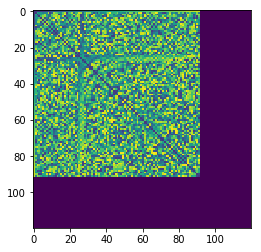

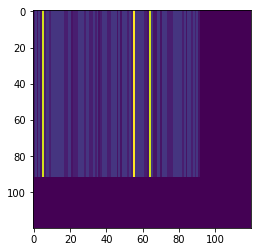

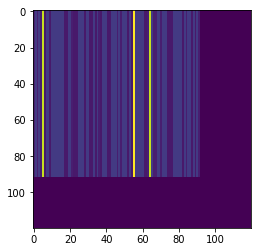

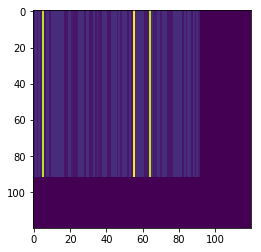

In [194]:
for i in range(4):
    plt.imshow(iv[:,:,i])
    plt.show()

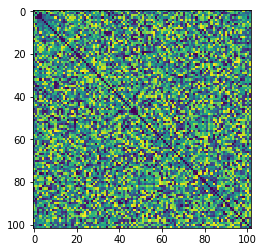

In [87]:
plt.imshow(distance_matrix)

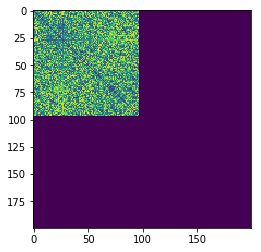

In [82]:
plt.imshow(a_sorted)

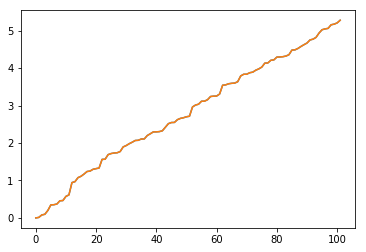

In [73]:
plt.plot(a_sorted[:,0])
plt.plot(a_sorted[0,:])

In [46]:
len(sort_idx)

102